In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'WenQuanYi Micro Hei', 'Heiti TC']
plt.rcParams['axes.unicode_minus'] = False

# 检查GPU是否可用
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 读取数据
X = pd.read_csv("E:/comorbidity/models/multi_features/all_features.csv", encoding='utf-8-sig')  
y = pd.read_excel("E:/comorbidity/models/multi_features/Y.xlsx")

# 查看y的数据，假设标签列名为 '标签'
y = y['标签']

# 标签编码
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# # 考虑到之前的特征都是标准化后的，所以这里不需要再标准化
# X_scaled = X.values

# 4. 特征标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集、验证集和测试集
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# 转换为PyTorch张量
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# 创建数据加载器
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 定义简化的Transformer模型（减少过拟合）
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.3)  # 增加dropout
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(0), :] * 0.1
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_heads=4, num_layers=2, dropout=0.3):
        super(TransformerModel, self).__init__()
        
        # 简化输入嵌入层
        self.input_embedding = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),  # 使用LayerNorm替代BatchNorm
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # 位置编码
        self.pos_encoder = PositionalEncoding(hidden_size)
        
        # 简化Transformer编码器
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=hidden_size,  # 减少feedforward维度
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_layers
        )
        
        # 简化分类层
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),  # 减少中间层大小
            nn.LayerNorm(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, num_classes)
        )
        
        # 权重初始化
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)  # 使用Xavier初始化
            if module.bias is not None:
                torch.nn.init.constant_(module.bias, 0)
        elif isinstance(module, (nn.LayerNorm, nn.BatchNorm1d)):
            torch.nn.init.constant_(module.bias, 0)
            torch.nn.init.constant_(module.weight, 1.0)
    
    def forward(self, x):
        # 输入嵌入
        x = self.input_embedding(x)
        x = x.unsqueeze(1)
        
        # 位置编码
        x = x.transpose(0, 1)
        x = self.pos_encoder(x)
        x = x.transpose(0, 1)
        
        # Transformer编码
        x = self.transformer_encoder(x)
        x = x.squeeze(1)
        
        return self.classifier(x)

# 检查实际特征维度
print(f"实际特征维度: {X_scaled.shape[1]}")
print(f"训练数据形状: {X_train.shape}")
print(f"测试数据形状: {X_test.shape}")

input_size = X_scaled.shape[1]
hidden_size = 64  # 减少隐藏层维度
num_classes = 4
num_heads = 4   # 减少注意力头数
num_layers = 2  # 减少transformer层数
dropout = 0.3   # 增加dropout率

print(f"模型输入维度设置为: {input_size}")
print(f"隐藏层维度: {hidden_size}, 注意力头数: {num_heads}, 每个头维度: {hidden_size//num_heads}")
print(f"Transformer层数: {num_layers}, Dropout率: {dropout}")


True
1
2.8.0.dev20250621+cu128
使用设备: cuda:0
实际特征维度: 789
训练数据形状: (57097, 789)
测试数据形状: (19033, 789)
模型输入维度设置为: 789
隐藏层维度: 64, 注意力头数: 4, 每个头维度: 16
Transformer层数: 2, Dropout率: 0.3


In [4]:
# 设置随机种子函数
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 训练和评估函数
def train_and_evaluate(seed):
    set_random_seed(seed)
    
    # 重新初始化模型
    model = TransformerModel(input_size, hidden_size, num_classes, num_heads, num_layers, dropout).to(device)
    
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.05)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.7)
    
    # 训练历史记录
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    best_val_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_patience = 10
    num_epochs = 50
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # 创建进度条
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), 
                          desc=f'运行{seed} Epoch {epoch+1}/{num_epochs}')
        
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # 更新进度条
            progress_bar.set_postfix({'loss': running_loss/(i+1), 'acc': 100.*correct/total})
        
        progress_bar.close()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # 验证
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler.step(val_loss)
        
        # 早停
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), f'best_transformer_model_{seed}.pth')
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                break
    
    # 加载最佳模型
    model.load_state_dict(torch.load(f'best_transformer_model_{seed}.pth'))
    
    # 测试评估
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, y_pred = torch.max(outputs, 1)
        y_pred_proba = torch.softmax(outputs, dim=1).cpu().numpy()
    
    y_pred = y_pred.cpu().numpy()
    y_test = y_test_tensor.cpu().numpy()
    
    # 计算weighted指标
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # 计算weighted AUC
    y_test_bin = label_binarize(y_test, classes=list(range(num_classes)))
    auc_weighted = roc_auc_score(y_test_bin, y_pred_proba, average='weighted', multi_class='ovr')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_weighted,
        'history': history,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'seed': seed
    }

# 运行10次实验
print("开始10次独立实验...")
results = []
for i in range(10):
    print(f"运行第{i+1}次实验 (seed={42+i})...")
    result = train_and_evaluate(42+i)
    results.append(result)
    print(f"第{i+1}次: 准确率={result['accuracy']:.4f}, F1={result['f1']:.4f}")

# 计算统计结果
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
stats = {}

for metric in metrics:
    values = [r[metric] for r in results]
    stats[metric] = {
        'mean': np.mean(values),
        'std': np.std(values),
        'values': values
    }

# 输出最终结果
print("\n" + "="*50)
print("最终结果 (平均值±标准差)")
print("="*50)
print(f"准确率: {stats['accuracy']['mean']:.4f} ± {stats['accuracy']['std']:.4f}")
print(f"精准率: {stats['precision']['mean']:.4f} ± {stats['precision']['std']:.4f}")
print(f"召回率: {stats['recall']['mean']:.4f} ± {stats['recall']['std']:.4f}")
print(f"F1值: {stats['f1']['mean']:.4f} ± {stats['f1']['std']:.4f}")
print(f"AUC值: {stats['auc']['mean']:.4f} ± {stats['auc']['std']:.4f}")

# 保存最后一次实验的预测结果用于后续可视化
final_result = results[-1]
y_pred = final_result['y_pred']
y_pred_proba = final_result['y_pred_proba']
y_test = y_test_tensor.cpu().numpy()
history = final_result['history']


开始10次独立实验...
运行第1次实验 (seed=42)...


运行42 Epoch 44/50: 100%|██████████| 447/447 [00:06<00:00, 69.40it/s, loss=0.816, acc=85.1]


第1次: 准确率=0.8316, F1=0.8272
运行第2次实验 (seed=43)...


运行43 Epoch 50/50: 100%|██████████| 447/447 [00:07<00:00, 62.70it/s, loss=0.812, acc=85.3]


第2次: 准确率=0.8322, F1=0.8279
运行第3次实验 (seed=44)...


运行44 Epoch 50/50: 100%|██████████| 447/447 [00:06<00:00, 69.87it/s, loss=0.815, acc=85.1]


第3次: 准确率=0.8317, F1=0.8270
运行第4次实验 (seed=45)...


运行45 Epoch 50/50: 100%|██████████| 447/447 [00:06<00:00, 68.53it/s, loss=0.813, acc=85.4]


第4次: 准确率=0.8338, F1=0.8282
运行第5次实验 (seed=46)...


运行46 Epoch 50/50: 100%|██████████| 447/447 [00:05<00:00, 88.84it/s, loss=0.812, acc=85.4]


第5次: 准确率=0.8326, F1=0.8292
运行第6次实验 (seed=47)...


运行47 Epoch 50/50: 100%|██████████| 447/447 [00:05<00:00, 87.81it/s, loss=0.819, acc=85]  


第6次: 准确率=0.8339, F1=0.8307
运行第7次实验 (seed=48)...


运行48 Epoch 50/50: 100%|██████████| 447/447 [00:04<00:00, 92.70it/s, loss=0.812, acc=85.5]


第7次: 准确率=0.8327, F1=0.8286
运行第8次实验 (seed=49)...


运行49 Epoch 41/50: 100%|██████████| 447/447 [00:05<00:00, 82.00it/s, loss=0.819, acc=84.9]


第8次: 准确率=0.8299, F1=0.8251
运行第9次实验 (seed=50)...


运行50 Epoch 50/50: 100%|██████████| 447/447 [00:06<00:00, 67.02it/s, loss=0.819, acc=85]  


第9次: 准确率=0.8322, F1=0.8273
运行第10次实验 (seed=51)...


运行51 Epoch 50/50: 100%|██████████| 447/447 [00:06<00:00, 73.90it/s, loss=0.821, acc=84.8]


第10次: 准确率=0.8304, F1=0.8273

最终结果 (平均值±标准差)
准确率: 0.8321 ± 0.0012
精准率: 0.8282 ± 0.0013
召回率: 0.8321 ± 0.0012
F1值: 0.8278 ± 0.0014
AUC值: 0.9340 ± 0.0010


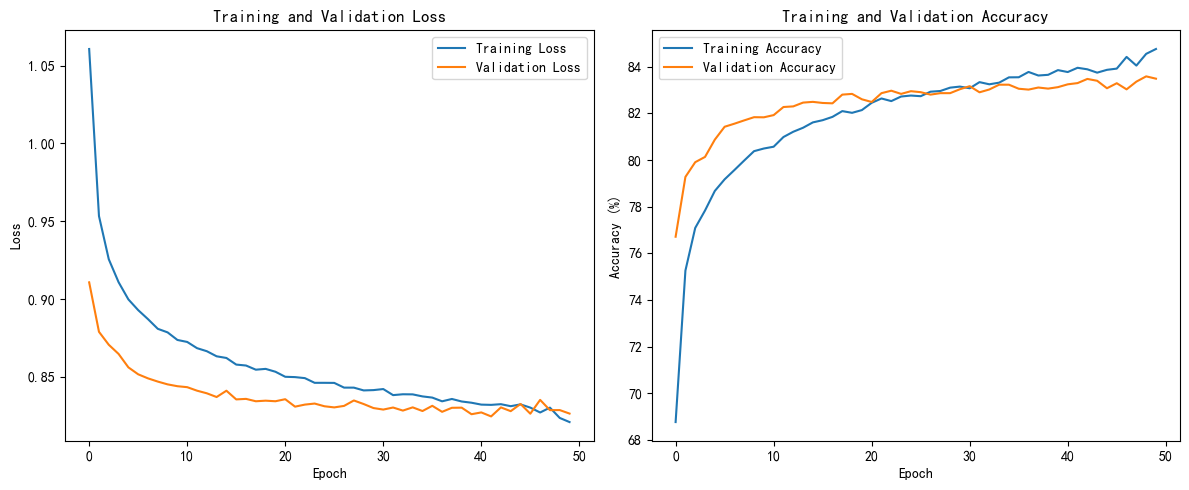

In [6]:
# 训练历史可视化绘制训练和验证损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

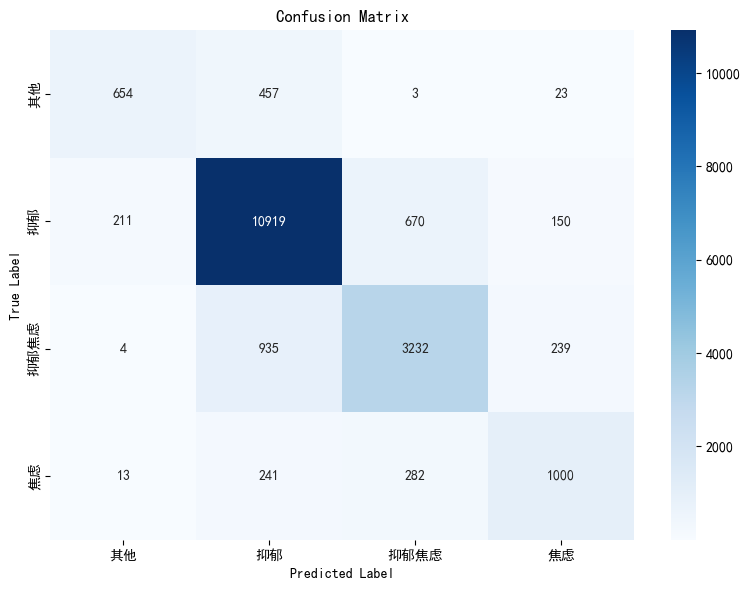

测试集准确率: 83.04%


In [7]:
# 混淆矩阵可视化
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# 计算测试准确率
test_accuracy = 100 * (y_pred == y_test).sum() / len(y_test)
print(f"测试集准确率: {test_accuracy:.2f}%")

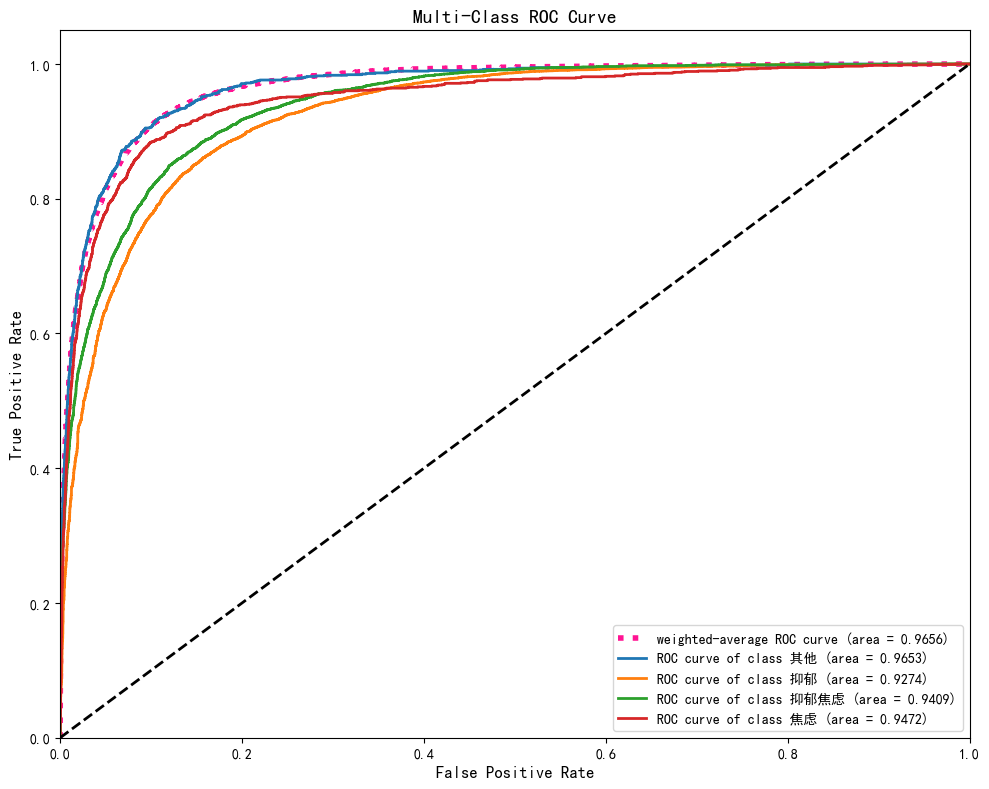

In [9]:
# 多分类ROC曲线可视化
n_classes = len(label_encoder.classes_)
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算微平均ROC曲线和AUC
fpr["weighted"], tpr["weighted"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

# 绘制所有类别的ROC曲线
plt.figure(figsize=(10, 8))
plt.plot(fpr["weighted"], tpr["weighted"],
         label='weighted-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["weighted"]),
         color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.4f})'
                   ''.format(label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-Class ROC Curve', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [ ]:
# 保存模型（可选）
# torch.save(model.state_dict(), 'transformer_model.pth')
